In [2]:
import ct_projector.projector.numpy as ct_projector
import ct_projector.projector.numpy.parallel as ct_para
import ct_projector.projector.cupy.fan_equiangular as ct_fan
import ct_projector.projector.numpy.fan_equiangluar as numpy_fan
import cupy as cp
import SimpleITK as sitk
import matplotlib.pyplot as plt
import numpy as np
import scipy.ndimage
import nibabel as nb
from scipy.ndimage import shift
import ct_basic as basic
import HeadCT_motion_correction_PAR.functions_collection as ff
import HeadCT_motion_correction_PAR.motion_simulator.transformation as transform

In [3]:
data_path = '/mnt/mount_zc_NAS/motion_correction/data/raw_data/nii-images/thin_slice/'
filename = os.path.join(data_path,'MO101701M000006/MO001A000007/img-nii-2.5/img.nii.gz')
_,spacing,affine = basic.basic_image_processing(filename)

sitk_img = sitk.ReadImage(filename)

img = sitk.GetArrayFromImage(sitk_img)
print(img.shape)
hu = np.copy(img[30:31,...]).astype(np.float32)

img = img[30:31,...][np.newaxis].astype(np.float32)
img = np.copy(img, 'C')
img = (img + 1000) / 1000
img[img < 0] = 0

# mask = np.zeros_like(img)
# mask[0, 0, 16:-16, 16:-16] = 1
# img = img * mask
print(img.shape)

(71, 234, 234)
(1, 1, 234, 234)


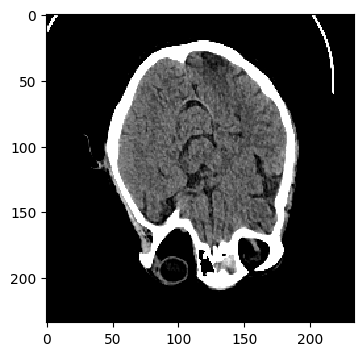

In [4]:
plt.figure(figsize=[4,4])
plt.imshow(img[0,0], 'gray', vmin=1, vmax=1.1)

In [5]:
ct_projector.set_device(0)
projector = ct_projector.ct_projector()
projector.from_file('./projector_fan.cfg')
projector.nx = img.shape[-1]
projector.ny = img.shape[-2]
projector.nz = 1
projector.nv = 1
spacing = sitk_img.GetSpacing()
projector.dx = spacing[0]
projector.dy = spacing[1]
projector.du = projector.dx / 2
projector.nu = 736
projector.nview = 1000
# for k in vars(projector):
#     print(k, '=', getattr(projector, k))
# angles = projector.get_angles()
angles = ff.get_angles_zc(1000, 360,0)

# motion experiment

In [6]:
# motion experiment
# define motion profile
t = np.linspace(0,9,10)
rot_angle_list = np.linspace(1,   10 , 10)
# rot_angle_list = np.asarray([0,1,2,3,4,5,6,7,5,3])
translation_list = np.linspace(1,   10 , 10)
spline_r = transform.interp_func(t, rot_angle_list)
spline_t = transform.interp_func(t, translation_list)
angle_shift = 1

# make FP
prjs_motion = []
time = np.linspace(0,9,10)
nview_per_step = len(angles) // time.shape[0]

for istep in range(0,time.shape[0]):
    tt = time[istep]
    rot_angle = angle_shift * spline_r([tt])[0]
    translate = spline_t([tt])[0]
    # print(tt, translate, rot_angle)

    current_img_ori = np.copy(img[0,...])

    # option 1
    _,_,_,transformation_matrix = transform.generate_transform_matrix([0,translate, translate],[rot_angle / 180 * np.pi,0,0],[1,1,1],current_img_ori.shape)
    transformation_matrix = transform.transform_full_matrix_offset_center(transformation_matrix, current_img_ori.shape)
    current_img = transform.apply_affine_transform(np.copy(current_img_ori), transformation_matrix, order = 1, cval =0 )


    # option 2
    # current_img = scipy.ndimage.shift(current_img_ori, (0,translate, translate), order = 1)
    # current_img = scipy.ndimage.rotate(current_img, rot_angle, axes = (1,2), reshape=False, order=1)
    

    # option 3
    # current_img = scipy.ndimage.rotate(current_img_ori, rot_angle, axes = (1,2), reshape=False, order=1)
    # current_img = scipy.ndimage.shift(current_img, (0,translate, translate), order = 1)


    current_img = current_img[np.newaxis,...]
    
    current_angles = angles[istep * nview_per_step:(istep + 1) * nview_per_step]
    current_prj = ct_para.distance_driven_fp(projector, current_img, current_angles)
    
    prjs_motion.append(current_prj)
prjs_motion = np.concatenate(prjs_motion, 1)
print(prjs_motion.shape)

# plt.imshow(prjs_motion[0, :, 0, :].T, 'gray', vmin=0, vmax=5 / 0.019)


(1, 1000, 1, 736)


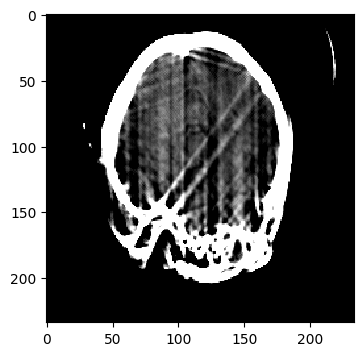

In [7]:
fprj = ct_para.ramp_filter(projector, prjs_motion, 'rl')
recon_motion = ct_para.distance_driven_bp(projector, fprj, angles, True)

plt.figure(figsize=[4,4])
plt.imshow(recon_motion[0, 0], 'gray', vmin=1, vmax=1.1)

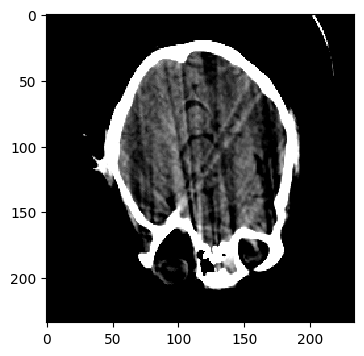

In [8]:
# motion correction from original projection (divide into 10 PARs)
pars = []
par_time = np.linspace(0,9,10)
nview_per_step = len(angles) // par_time.shape[0]

for istep in range(par_time.shape[0]):
    tt = par_time[istep]
    rot_angle = angle_shift * spline_r([tt])[0]
    translate = spline_t([tt])[0]

    current_angles = angles[istep * nview_per_step:(istep + 1) * nview_per_step]
    current_prj = prjs_motion[:, istep * nview_per_step:(istep + 1) * nview_per_step, ...]
    fprj = ct_para.ramp_filter(projector, current_prj, 'rl')
    recon = ct_para.distance_driven_bp(projector, fprj, current_angles, True)
    
    current_img = np.copy(recon[0,...])

    # option 1
    _,_,_,transformation_matrix = transform.generate_transform_matrix([0,-translate, -translate],[-rot_angle / 180 * np.pi,0,0],[1,1,1],current_img.shape, which_one_is_first='translation')
    transformation_matrix = transform.transform_full_matrix_offset_center(transformation_matrix, current_img.shape)
    current_img = transform.apply_affine_transform(current_img, transformation_matrix, order = 1, cval = np.min(current_img))

    # option 2
    # current_img = scipy.ndimage.rotate(current_img, -rot_angle, axes=(1, 2), reshape=False, order=1)
    # current_img = scipy.ndimage.shift(current_img, (0, -translate, -translate))

    # option 3
    # current_img = scipy.ndimage.shift(current_img, (0, -translate, -translate))
    # current_img = scipy.ndimage.rotate(current_img, -rot_angle, axes=(1, 2), reshape=False, order=1)
    
    
    current_img = current_img[np.newaxis,...]

    pars.append(current_img)
recon_mc_origin = np.mean(pars, 0)

plt.figure(figsize=[4,4])
plt.imshow(recon_mc_origin[0, 0], 'gray', vmin=1, vmax=1.1)

(1000,)


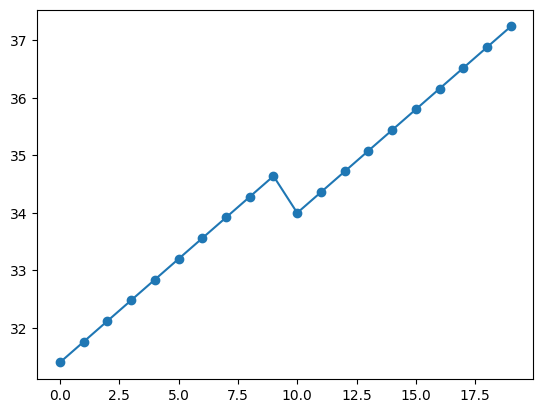

In [9]:
# solve the angle overlapping problem
# Calculate the weights for each projection
# first find the direction of each projection by applying the rotation matrix (in this case, it is just the rotation angle)
# then align all the angles sequentially
# at last, the weight (d_theta) will the average between the distance to the angle in front and the next one.

# calculate the direction of each projection
prj_dirs = []
for istep in range(par_time.shape[0]):
    tt = par_time[istep]
    rot_angle = angle_shift * spline_r([tt])[0]

    current_angles = angles[istep * nview_per_step:(istep + 1) * nview_per_step]
    
    new_angles = current_angles - rot_angle  / 180 * np.pi  #######IMPORTANT: use current-angle + rot_angle if use scipy.ndimage.rotate, use current-angle - rot_angle if use affine transform
    # print(istep, np.min(new_angles / np.pi*180), np.max(new_angles / np.pi*180))
    prj_dirs.append(new_angles)
prj_dirs = np.concatenate(prj_dirs, 0)
print(prj_dirs.shape)

plt.plot(prj_dirs[nview_per_step - 10:nview_per_step + 10]/np.pi*180, 'o-')

In [10]:
dangle = np.pi * 2 / len(angles)

iphases = np.floor(prj_dirs / np.pi)
warped_angles = prj_dirs - iphases * np.pi

ind_sorted_angles = np.argsort(warped_angles)
sorted_angles = warped_angles[ind_sorted_angles]

# first angle
w0 = (sorted_angles[1] - (sorted_angles[-1] - np.pi)) / dangle / 2

# last angle
wn = ((sorted_angles[0] + np.pi) - sorted_angles[-2]) / dangle / 2

weights = [w0]
for i in range(1, len(sorted_angles) - 1):
    weights.append((sorted_angles[i + 1] - sorted_angles[i - 1]) / dangle / 2)
weights.append(wn)
weights = np.array(weights)

# convert weights back to the original order
weights = weights[ind_sorted_angles.argsort()]

0.0 1.0 1.0
1.0 2.0 2.0
2.0 3.0 3.0
3.0 4.0 4.0
4.0 5.0 5.0
5.0 6.0 6.0
6.0 7.0 7.0
7.0 8.0 8.0
8.0 9.0 9.0
9.0 10.0 10.0


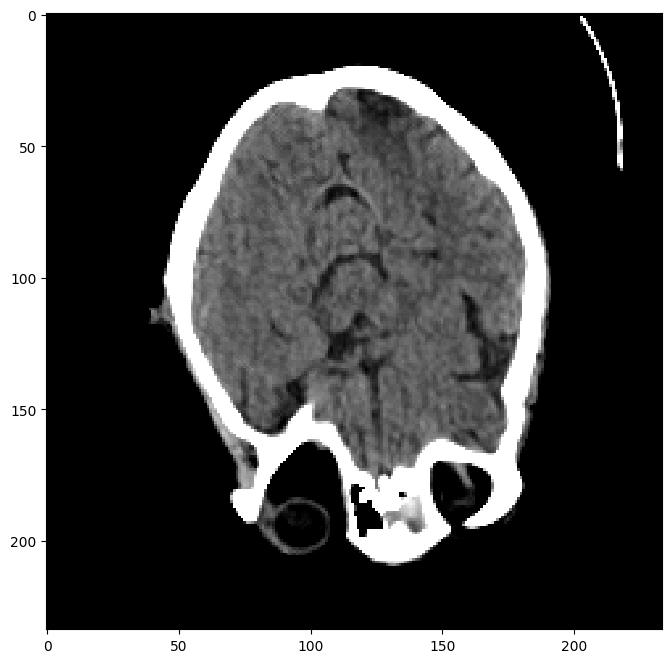

In [11]:
# motion correction from weighted projection
pars = []
par_time = np.linspace(0,9,10)
nview_per_step = len(angles) // par_time.shape[0]

for istep in range(par_time.shape[0]):
    tt = par_time[istep]
    rot_angle = angle_shift * spline_r([tt])[0]
    translate = spline_t([tt])[0]
    print(tt, translate, rot_angle)
   

    current_angles = angles[istep * nview_per_step:(istep + 1) * nview_per_step]
    current_prj = prjs_motion[:, istep * nview_per_step:(istep + 1) * nview_per_step, ...]
    current_weights = weights[istep * nview_per_step:(istep + 1) * nview_per_step]
    current_prj = current_prj * current_weights[np.newaxis, :, np.newaxis, np.newaxis]
    fprj = ct_para.ramp_filter(projector, current_prj, 'rl')
    recon = ct_para.distance_driven_bp(projector, fprj, current_angles, True)
    
    current_img = np.copy(recon[0,...])
    # option 1
    _,_,_,transformation_matrix = transform.generate_transform_matrix([0,-translate, -translate],[-rot_angle/180*np.pi,0,0],[1,1,1],current_img.shape,which_one_is_first='translation')
    transformation_matrix = transform.transform_full_matrix_offset_center(transformation_matrix, current_img.shape)
    current_img = transform.apply_affine_transform(np.copy(current_img), transformation_matrix, order = 1, cval = 0)

    # option 2
    # current_img = scipy.ndimage.rotate(current_img, -rot_angle, axes=(1, 2), reshape=False, order=1)
    # current_img = scipy.ndimage.shift(current_img, (0, -translate, -translate))

    # option 3
    # current_img = scipy.ndimage.shift(current_img, (0, -translate, -translate))
    # current_img = scipy.ndimage.rotate(current_img, -rot_angle, axes=(1, 2), reshape=False, order=1)
   
    
    current_img = current_img[np.newaxis,...]

    # print(tt, np.mean(np.abs(current_img2 - current_img[0,...])))

    pars.append(current_img)
recon_mc_origin = np.mean(pars, 0) * 2

plt.figure(figsize=[8, 8])
plt.imshow(recon_mc_origin[0, 0], 'gray', vmin=1, vmax=1.1)

In [350]:
ii = np.rollaxis(nb.load(filename).get_fdata(),2,0)
ii = ii[30,:,:]
ii = ii[np.newaxis,...]
print(ii.shape)

(1, 234, 234)


In [358]:
_,_,_,transformation_matrix = transform.generate_transform_matrix([0,4,0],[5/180*np.pi,0,0],[1,1,1],ii.shape)
transformation_matrix = transform.transform_full_matrix_offset_center(transformation_matrix, ii.shape)
a = transform.apply_affine_transform(np.copy(ii), transformation_matrix, order = 1, cval = 0)

b = scipy.ndimage.rotate(np.copy(ii), -5, axes=(1, 2), reshape=False, order=1)
b= scipy.ndimage.shift(b, (0, -4,0), order = 1 )

print(np.mean(np.abs(a-b)))

11.244777889685162
